In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, f1_score
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer 
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('TelcoChurn.csv')
df.head()

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
0          No          No              No  Month-to-month              Yes   
1          No          No              No        One year               No   
2          No          No              No  Month-to-month              Yes   
3         Yes          No              No        One year               No   
4          No          No              No  Month-to-month              Yes   

               PaymentMethod MonthlyCharges  TotalCharges Churn  
0           Electronic check          29.85         29.85    No  
1               Mailed check          56.95        1889.5    No  
2               Mailed check          53.85        108.15   Yes  
3  Bank transfer (automatic)          42.30       1840.75    No  
4           Electronic check          70.70        151.65   Yes  

[5 rows x 21 columns]

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [4]:
for col in df:
    print(f"{col}: {df[col].value_counts()} unique values")
    print(10*"-----")

customerID: customerID
7590-VHVEG    1
5575-GNVDE    1
3668-QPYBK    1
7795-CFOCW    1
9237-HQITU    1
             ..
6840-RESVB    1
2234-XADUH    1
4801-JZAZL    1
8361-LTMKD    1
3186-AJIEK    1
Name: count, Length: 7043, dtype: int64 unique values
--------------------------------------------------
gender: gender
Male      3555
Female    3488
Name: count, dtype: int64 unique values
--------------------------------------------------
SeniorCitizen: SeniorCitizen
0    5901
1    1142
Name: count, dtype: int64 unique values
--------------------------------------------------
Partner: Partner
No     3641
Yes    3402
Name: count, dtype: int64 unique values
--------------------------------------------------
Dependents: Dependents
No     4933
Yes    2110
Name: count, dtype: int64 unique values
--------------------------------------------------
tenure: tenure
1     613
72    362
2     238
3     200
4     176
     ... 
28     57
39     56
44     51
36     50
0      11
Name: count, Length: 73, 

In [5]:
# TotalCharges düzeltme
df['TotalCharges'] = df['TotalCharges'].replace(' ', 0).astype(float)

# customerID drop
df.drop('customerID', axis=1, inplace=True)

# Feature engineering - Basic
df['IsMonthToMonth'] = np.where(df['Contract'] == 'Month-to-month', 1, 0)
df['IsAutoPay'] = np.where(df['PaymentMethod'].str.contains('automatic'), 1, 0)
df['HasPhoneService'] = np.where(df['PhoneService'] == 'Yes', 1, 0)
df['HasInternetService'] = np.where(df['InternetService'] == 'No', 0, 1)
df['IsAlone'] = np.where((df['Partner'] == 'No') & (df['Dependents'] == 'No'), 1, 0)

In [6]:
# Feature engineering - Financial
df['AvgMonthlyCharges'] = df['TotalCharges'] / (df['tenure'] + 1)
df['PriceIncrease'] = df['MonthlyCharges'] / (df['AvgMonthlyCharges'] + 0.01)
df['ExpectedRevenue'] = df['MonthlyCharges'] * 12

# Feature engineering - Service Combinations
service_cols = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
                'TechSupport', 'StreamingTV', 'StreamingMovies']
df['TotalServices'] = sum((df[col] == 'Yes').astype(int) for col in service_cols)
df['IsPremiumCustomer'] = (df['TotalServices'] >= 4).astype(int)
df['NoExtraServices'] = (df['TotalServices'] == 0).astype(int)

# Feature engineering - Risk Factors
df['HighRiskProfile'] = ((df['Contract'] == 'Month-to-month') & 
                          (df['PaymentMethod'] == 'Electronic check')).astype(int)
df['IsNewCustomer'] = (df['tenure'] <= 6).astype(int)
df['LoyaltyScore'] = df['tenure'] * (3 - df['IsMonthToMonth'] * 2)
df['FirstYear'] = (df['tenure'] <= 12).astype(int)

# Feature engineering - Internet Patterns
df['FiberNoSecurity'] = ((df['InternetService'] == 'Fiber optic') & 
                          (df['OnlineSecurity'] == 'No')).astype(int)

# Feature engineering - Demographics
df['SeniorAlone'] = ((df['SeniorCitizen'] == 1) & (df['IsAlone'] == 1)).astype(int)
df['YoungFamily'] = ((df['SeniorCitizen'] == 0) & 
                      (df['Partner'] == 'Yes') & 
                      (df['Dependents'] == 'Yes')).astype(int)


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 38 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              7043 non-null   object 
 1   SeniorCitizen       7043 non-null   int64  
 2   Partner             7043 non-null   object 
 3   Dependents          7043 non-null   object 
 4   tenure              7043 non-null   int64  
 5   PhoneService        7043 non-null   object 
 6   MultipleLines       7043 non-null   object 
 7   InternetService     7043 non-null   object 
 8   OnlineSecurity      7043 non-null   object 
 9   OnlineBackup        7043 non-null   object 
 10  DeviceProtection    7043 non-null   object 
 11  TechSupport         7043 non-null   object 
 12  StreamingTV         7043 non-null   object 
 13  StreamingMovies     7043 non-null   object 
 14  Contract            7043 non-null   object 
 15  PaperlessBilling    7043 non-null   object 
 16  Paymen

In [ ]:
#Find Outliers with IQR
def find_outliers_iqr(df, threshold = 1.5):
    outlier_summary = {}


    numeric_cols = df.select_dtypes(include=["float64", "int64"]).columns
   
    for col in numeric_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1


        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR


        outliers = df[ (df[col] < lower_bound) | (df[col] > upper_bound)]
       
        outlier_summary[col] = {
            "outlier_count" : outliers.shape[0],
            "outlier_percentage" : 100 * outliers.shape[0] / df.shape[0],
            "lower_bound" : lower_bound,
            "upper_bound" : upper_bound
        }
    return pd.DataFrame(outlier_summary)
outlier_info = find_outliers_iqr(df)
print(outlier_info)

                    SeniorCitizen  tenure  MonthlyCharges  TotalCharges  \
outlier_count         1142.000000     0.0           0.000         0.000   
outlier_percentage      16.214681     0.0           0.000         0.000   
lower_bound              0.000000   -60.0         -46.025     -4683.525   
upper_bound              0.000000   124.0         171.375      8868.675   

                    IsMonthToMonth  IsAutoPay  HasPhoneService  \
outlier_count                  0.0        0.0       682.000000   
outlier_percentage             0.0        0.0         9.683374   
lower_bound                   -1.5       -1.5         1.000000   
upper_bound                    2.5        2.5         1.000000   

                    HasInternetService  IsAlone  AvgMonthlyCharges  ...  \
outlier_count              1526.000000      0.0           0.000000  ...   
outlier_percentage           21.666903      0.0           0.000000  ...   
lower_bound                   1.000000     -1.5         -62.142381  

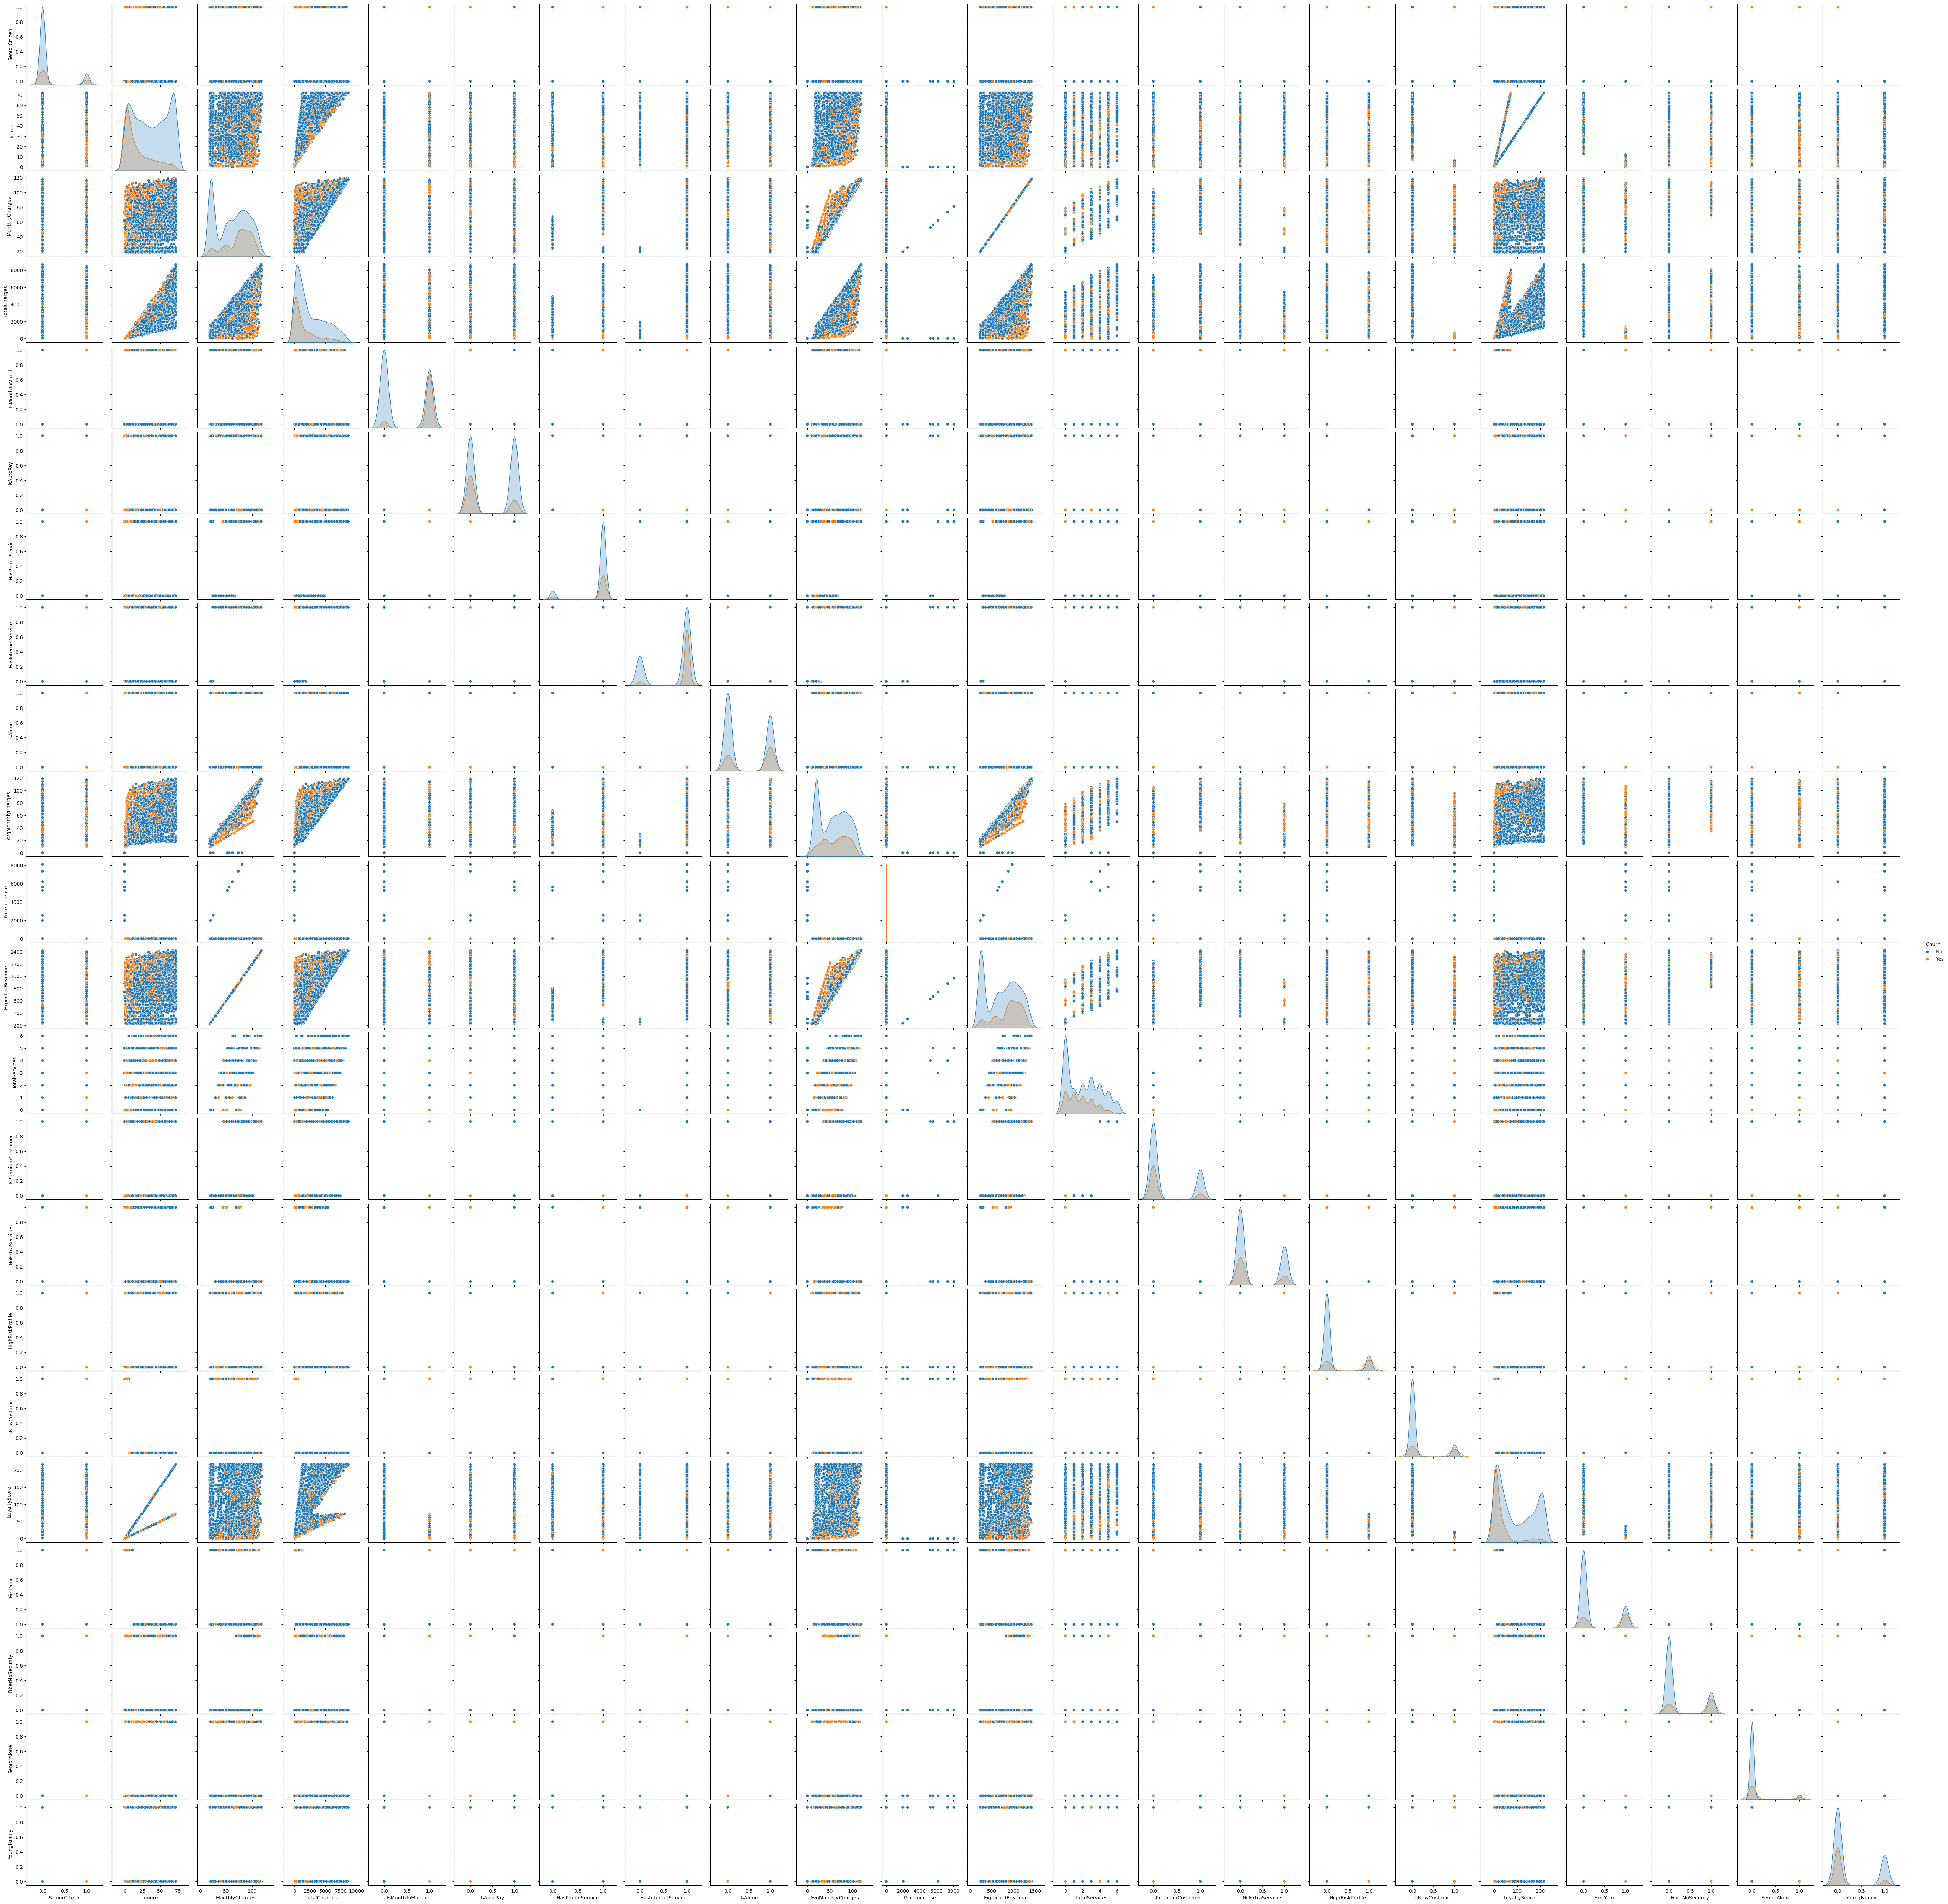

In [ ]:
#Pairplot
sns.pairplot(df, hue='Churn')

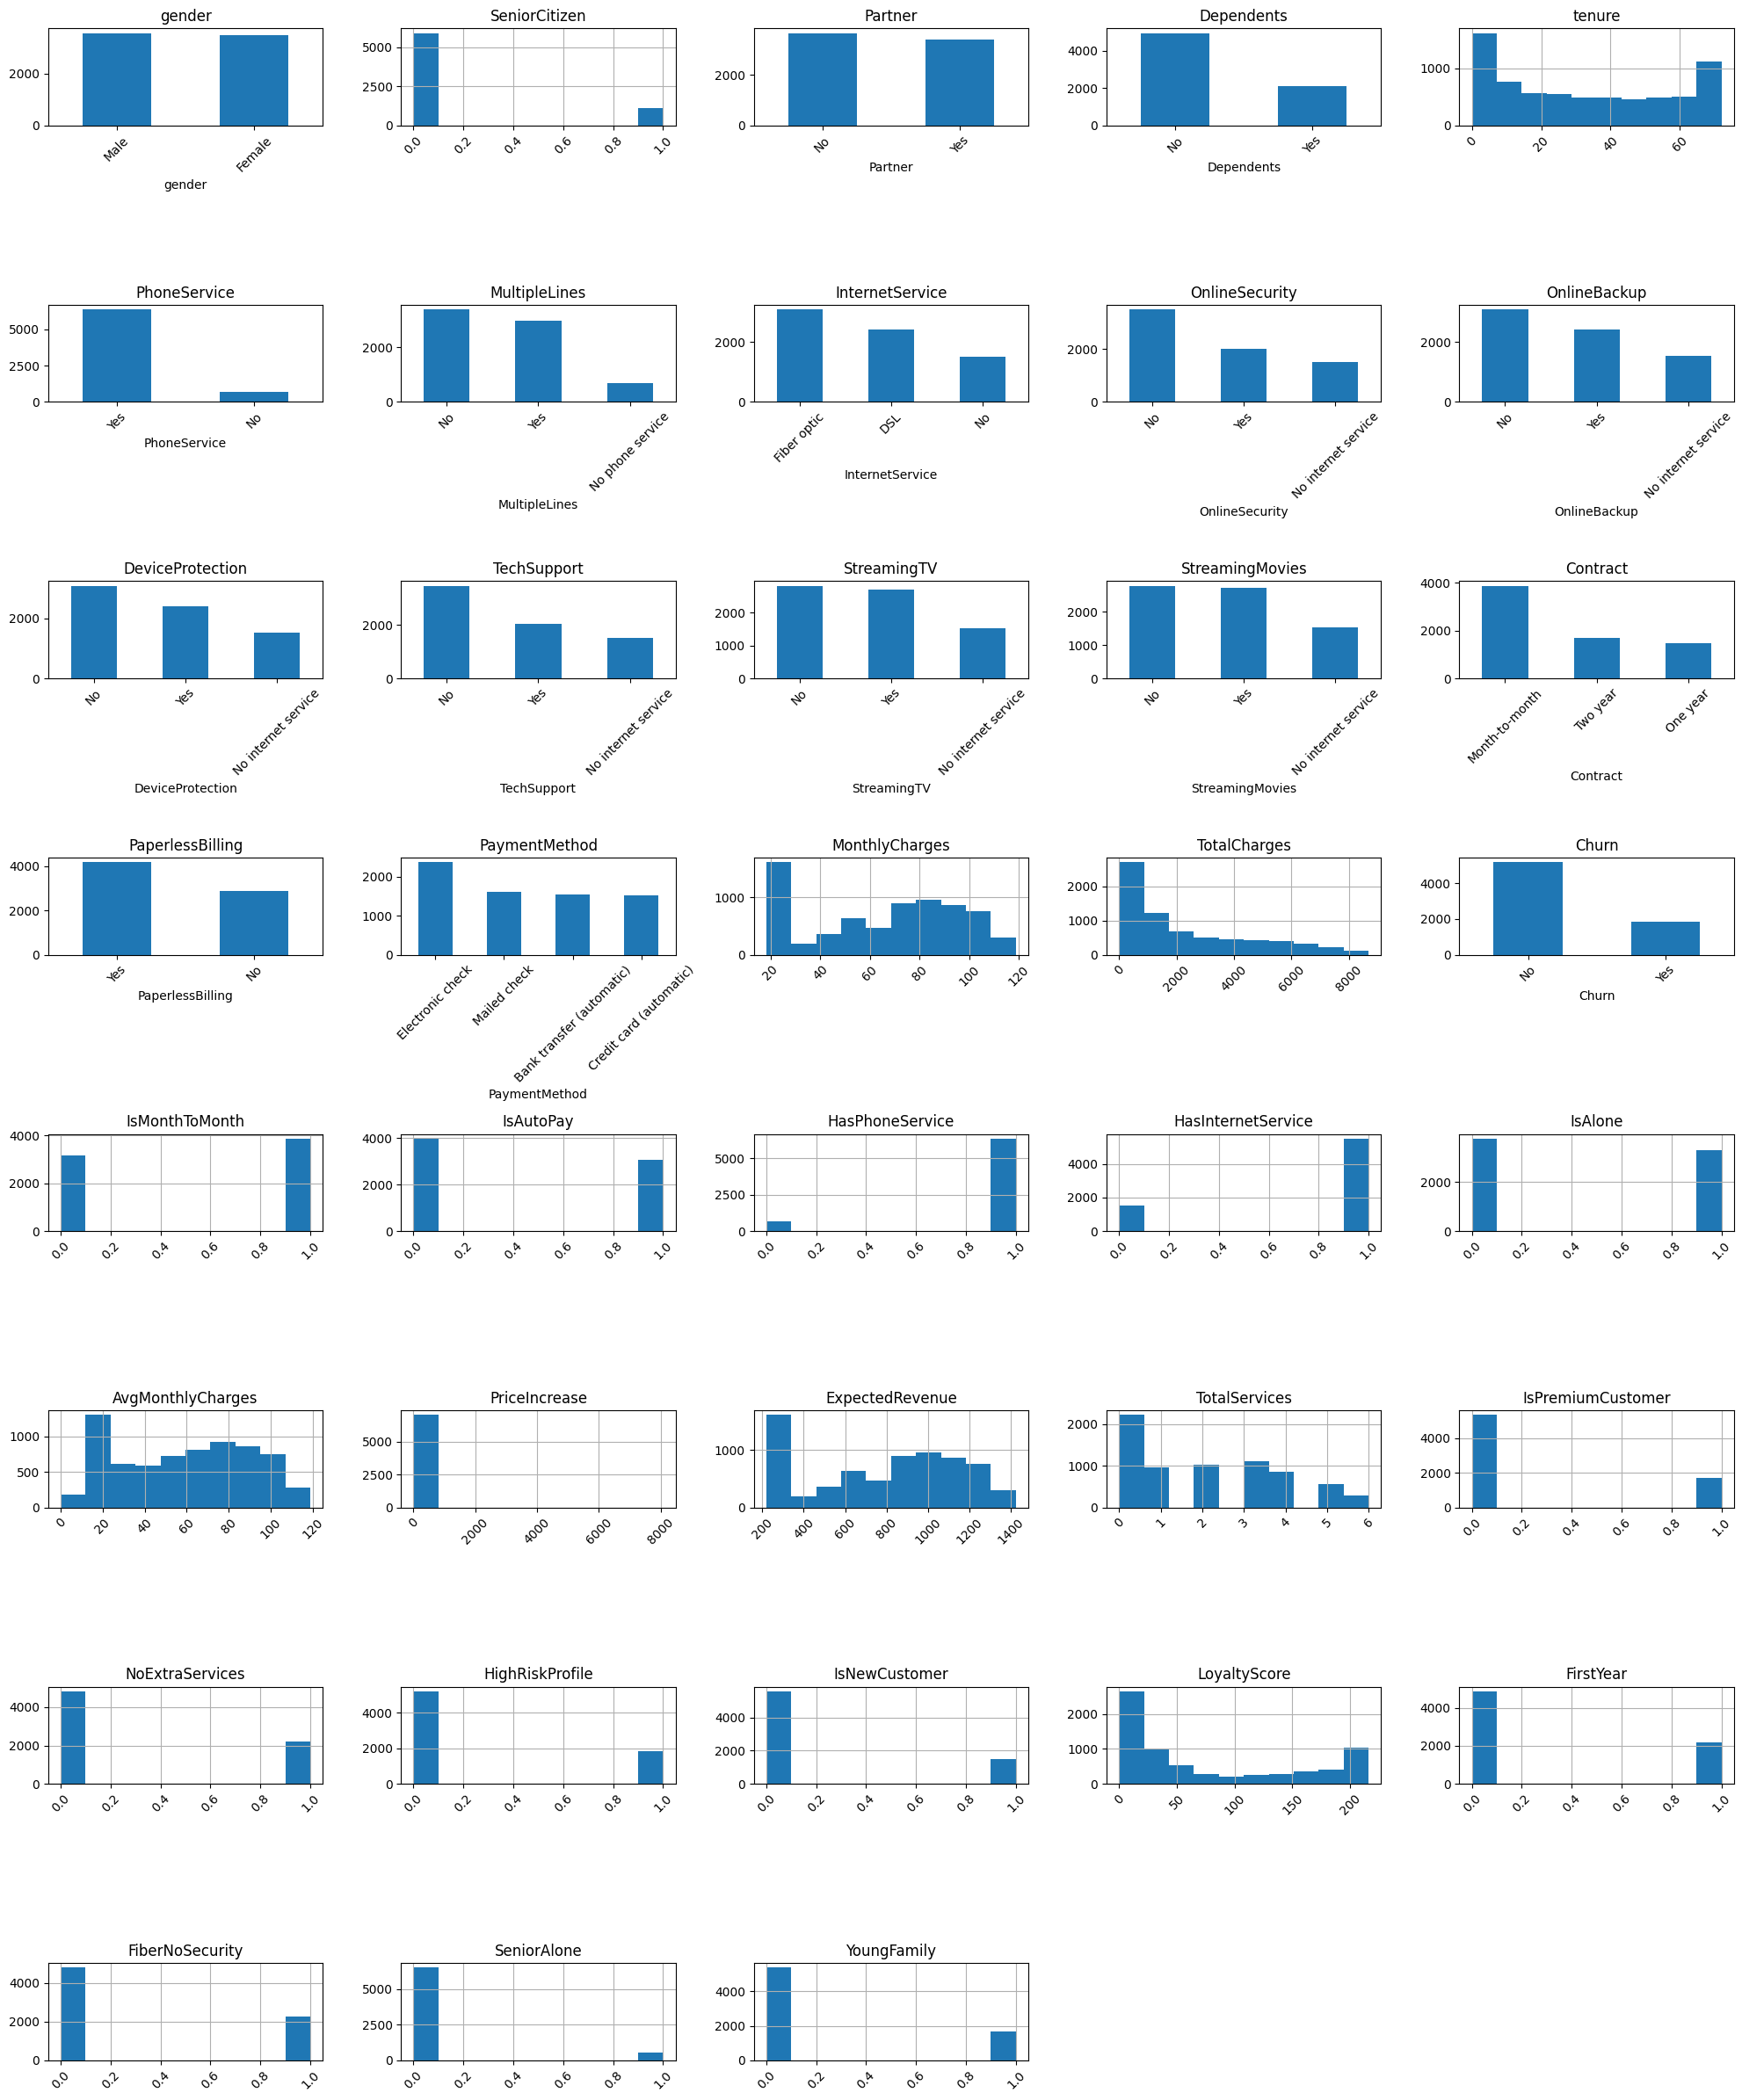

In [10]:
# Create histograms for all columns
num_cols = len(df.columns)
nrows = (num_cols + 4) // 5  # Calculate rows needed for 5 columns per row
fig, axes = plt.subplots(nrows=nrows, ncols=5, figsize=(20, nrows*3))
axes = axes.ravel()

for i, col in enumerate(df.columns):
    if df[col].dtype in ['int64', 'float64']:
        df[col].hist(ax=axes[i])
    else:
        df[col].value_counts().plot(kind='bar', ax=axes[i])
    
    axes[i].set_title(col)
    axes[i].tick_params(axis='x', rotation=45)

# Hide any unused subplots
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [11]:
df.isnull().sum()

gender                0
SeniorCitizen         0
Partner               0
Dependents            0
tenure                0
PhoneService          0
MultipleLines         0
InternetService       0
OnlineSecurity        0
OnlineBackup          0
DeviceProtection      0
TechSupport           0
StreamingTV           0
StreamingMovies       0
Contract              0
PaperlessBilling      0
PaymentMethod         0
MonthlyCharges        0
TotalCharges          0
Churn                 0
IsMonthToMonth        0
IsAutoPay             0
HasPhoneService       0
HasInternetService    0
IsAlone               0
AvgMonthlyCharges     0
PriceIncrease         0
ExpectedRevenue       0
TotalServices         0
IsPremiumCustomer     0
NoExtraServices       0
HighRiskProfile       0
IsNewCustomer         0
LoyaltyScore          0
FirstYear             0
FiberNoSecurity       0
SeniorAlone           0
YoungFamily           0
dtype: int64

In [ ]:
#Columns 
binary_cols = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
               'PaperlessBilling', 'IsMonthToMonth', 'IsAutoPay', 'HasPhoneService',
               'HasInternetService', 'IsAlone', 'IsPremiumCustomer', 'NoExtraServices',
               'HighRiskProfile', 'IsNewCustomer', 'FirstYear', 'FiberNoSecurity',
               'SeniorAlone', 'YoungFamily']
cat_cols = ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
            'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
            'Contract', 'PaymentMethod']
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges', 'AvgMonthlyCharges', 
            'PriceIncrease', 'ExpectedRevenue', 'TotalServices', 'LoyaltyScore']

In [ ]:
# Pipelines
num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

cat_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

binary_cols_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='if_binary', handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', num_pipeline, num_cols),
    ('cat', cat_pipeline, cat_cols),
    ('bin', binary_cols_pipeline, binary_cols)
], remainder='drop')

In [ ]:
#Class imbalance handling
X = df.drop('Churn', axis=1)
y = df['Churn'].map({'No': 0, 'Yes': 1})
class_ratio = (y == 0).sum() / (y == 1).sum()
print(f"Class imbalance ratio: {class_ratio:.2f}")
print(f"Churn distribution:\n{y.value_counts()}")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

Class imbalance ratio: 2.77
Churn distribution:
Churn
0    5174
1    1869
Name: count, dtype: int64


In [15]:
from sklearn.ensemble import RandomForestClassifier

# RandomForest parameter grid
rf_params = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 5, 7, 9, 11, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}
pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model',RandomForestClassifier())
])

In [ ]:
# RandomizedSearchCV
rf_search = RandomizedSearchCV(
    pipeline_rf, 
    {'model__' + k: v for k, v in rf_params.items()},
    n_iter=20,
    scoring='f1',
    cv=5,
    verbose=1,
    n_jobs=-1,
    random_state=42
)
rf_search.fit(X_train, y_train)
y_pred = rf_search.predict(X_test)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [17]:
print("\nResults:")
print(f"Best params: {rf_search.best_params_}")
print(classification_report(y_test, y_pred))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred):.4f}")
print(f"Accuracy Score: {accuracy_score(y_test, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")


Results:
Best params: {'model__n_estimators': 100, 'model__min_samples_split': 10, 'model__min_samples_leaf': 4, 'model__max_features': 'log2', 'model__max_depth': 7, 'model__bootstrap': False}
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1294
           1       0.67      0.49      0.57       467

    accuracy                           0.80      1761
   macro avg       0.75      0.70      0.72      1761
weighted avg       0.79      0.80      0.79      1761

ROC AUC Score: 0.7023
Accuracy Score: 0.8018
F1 Score: 0.5675


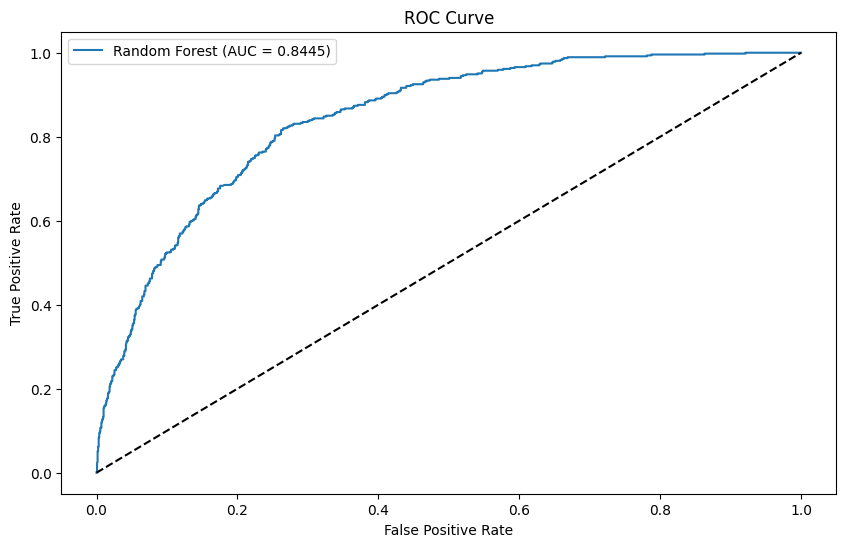

In [ ]:
#Roc Curve
from sklearn.metrics import roc_curve, precision_recall_curve
plt.figure(figsize=(10,6))
roc = roc_auc_score(y_test, rf_search.predict_proba(X_test)[:, 1])
fpr, tpr, _ = roc_curve(y_test, rf_search.predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {roc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

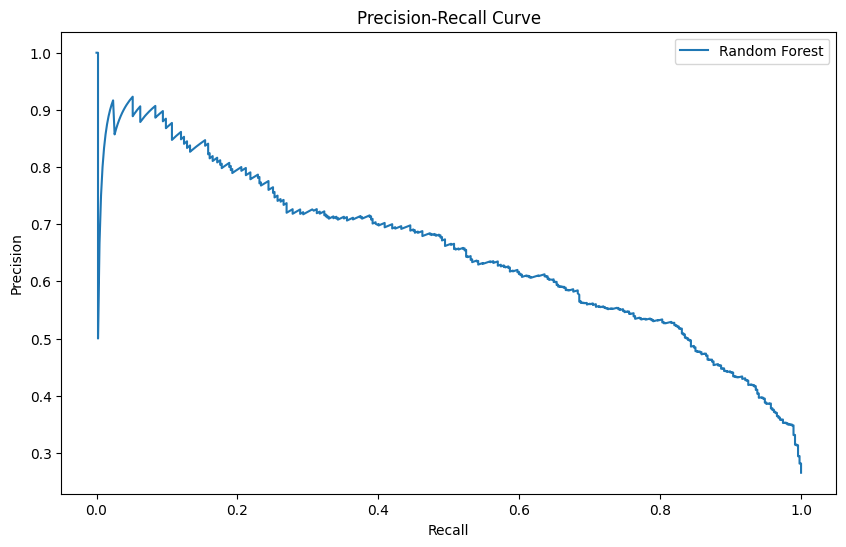

In [ ]:
#RecalL Curve
y_proba = rf_search.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
plt.figure(figsize=(10,6))
plt.plot(recall, precision, label='Random Forest')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

In [29]:
# Feature importance
print("\n" + "="*50)
print("Top 15 Most Important Features")
print("="*50)
feature_names = rf_search.best_estimator_.named_steps['preprocessor'].get_feature_names_out()
feature_importance = rf_search.best_estimator_.named_steps['model'].feature_importances_
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False).head(30)
print(importance_df)


Top 15 Most Important Features
                                      feature  importance
45                      bin__IsMonthToMonth_1    0.094680
32               cat__Contract_Month-to-month    0.076177
7                           num__LoyaltyScore    0.073065
52                     bin__HighRiskProfile_1    0.065023
0                                 num__tenure    0.058657
55                     bin__FiberNoSecurity_1    0.053124
4                          num__PriceIncrease    0.044854
12           cat__InternetService_Fiber optic    0.044020
54                           bin__FirstYear_1    0.041558
14                     cat__OnlineSecurity_No    0.038660
2                           num__TotalCharges    0.038575
23                        cat__TechSupport_No    0.034432
53                       bin__IsNewCustomer_1    0.029757
1                         num__MonthlyCharges    0.028411
5                        num__ExpectedRevenue    0.027330
3                      num__AvgMonthlyCh

In [20]:
import pickle
with open('rf_telco_churn_model.pkl', 'wb') as f:
    pickle.dump(pipeline_rf, f)